# Classify Waste Products Using Transfer Learning

In [1]:
# Import dependencies
import numpy as np
import os
import glob


from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Task 1: Print Tensorflow version
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.18.0


In [3]:
import requests
import zipfile
from tqdm import tqdm

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"

print("Downloading file")
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


def extract_file_with_progress(file_name):
    print("Extracting file with progress")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist()
        with tqdm(total=len(members), unit='file') as progress_bar:
            for member in members:
                zip_ref.extract(member)
                progress_bar.update(1)
    print("Finished extracting file")


extract_file_with_progress(file_name)

print("Finished extracting file")
os.remove(file_name)

Extracting file with progress


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1207/1207 [00:05<00:00, 222.64file/s]

Finished extracting file
Finished extracting file


In [4]:
# Define path dataset base
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

# Task 2: Create a `test_generator` using the `test_datagen` object
test_generator = test_datagen.flow_from_directory(
    directory=path_test,
    class_mode='binary',
    seed=seed,
    batch_size=batch_size,
    shuffle = False,
    target_size=(img_rows, img_cols),
)

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [5]:
# Task 3: print the length of the `train_generator`
print(len(train_generator))

25


Labels: [np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O')]


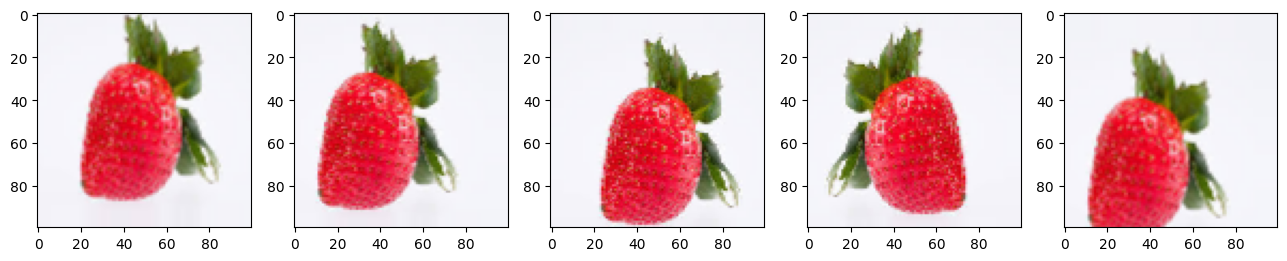

In [6]:
from pathlib import Path

IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]

In [7]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

In [8]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers:
    layer.trainable = False

In [9]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Task 4: Summary the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
# Task 5: Compile the model
for layer in basemodel.layers:
    layer.trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler


checkpoint_path='O_R_tlearn_vgg16.keras'

# define step decay function
class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss',
                    patience = 4,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

extract_feat_model = model.fit(train_generator,
                               steps_per_epoch=5,
                               epochs=10,
                               callbacks = callbacks_list_,
                               validation_data=val_generator,
                               validation_steps=val_generator.samples // batch_size,
                               verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 853ms/step - accuracy: 0.4891 - loss: 0.7829lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.4909 - loss: 0.7800 - val_accuracy: 0.7656 - val_loss: 0.5635 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.6885 - loss: 0.5823lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6936 - loss: 0.5758 - val_accuracy: 0.7917 - val_loss: 0.5003 - learning_rate: 9.0484e-05
Epoch 3/10


In [ ]:
# Task 6: Plot Train vs Val accuracy
plt.plot(extract_feat_model.history['accuracy'], label='Train Accuracy')
plt.plot(extract_feat_model.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy - Extract Feature Model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Fine-tuning
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers:
    layer.trainable = False

display([layer.name for layer in basemodel.layers])

set_trainable = False

for layer in basemodel.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in basemodel.layers:
    print(f"{layer.name}: {layer.trainable}")


model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss',
                    patience = 4,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator,
                    steps_per_epoch=5,
                    epochs=10,
                    callbacks = callbacks_list_,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size,
                    verbose=1)

In [ ]:
# Task 7: Plot Loss - Fine Tune
plt.plot(fine_tune_model.history['loss'], label='Train Loss')
plt.plot(fine_tune_model.history['val_loss'], label='Val Loss')
plt.title("Loss - Fine-Tuned Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Task 8: Plot Accuracy - Fine Tune
plt.plot(fine_tune_model.history['accuracy'], label='Train Accuracy')
plt.plot(fine_tune_model.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy - Fine-Tuned Model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
from pathlib import Path

# Load saved models
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

# Load test images
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions for both models
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

# Convert predictions to class labels
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

# Print classification report for both models
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))

In [ ]:
# Plot one of the images with actual label and predicted label as title
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

In [ ]:
# Task 9: Plot a test image using Extract Features Model (index_to_plot = 1)
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

In [ ]:
# Task 10: Plot a test image using Fine-Tuned Model (index_to_plot = 1)
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Fine-Tuned Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_fine_tune_model[index_to_plot],
    )

### Author

Mateus Andrade